In [110]:
from ipywidgets import widgets
from IPython.display import display
from datetime import datetime
import maped
import pandas as pd
import datetime

import numpy as np

from astroquery.jplhorizons import Horizons

from astropy.coordinates import get_sun, get_body, EarthLocation, AltAz
from astropy.time import Time
import astropy.units as u


In [ ]:
# --- Create the DatePicker widget ---
date_picker = widgets.DatePicker(
    description='Select Date:',
    disabled=False,
    value=datetime.date(2025, 8, 16) # Example initial date
)

# --- Display the DatePicker ---
display(date_picker)

DatePicker(value=datetime.date(2025, 8, 16), description='Select Date:')

In [5]:


date_picker.value.strftime("%Y-%m-%d")

'2025-08-16'

In [6]:
observatory_code_input = widgets.Dropdown(
    options=pd.read_csv('C:/Users/michi/OneDrive/Escritorio/phase_curves_project/MPC_observatory_codes/MPC_OBS_CODES.csv').Code.to_list(),
    value='Y28',
    description='Observatory code:',
    style={'description_width': 'initial'}
)
display(observatory_code_input)



Dropdown(description='Observatory code:', index=2500, options=('000', '001', '002', '003', '004', '005', '006'…

In [ ]:

observatory_code_input.value



'Y28'

In [14]:
import logi
MPC_CODES_FILE = 'C:/Users/michi/OneDrive/Escritorio/phase_curves_project/MPC_observatory_codes/MPC_OBS_CODES.csv'
site_longitude_360, site_latitude, site_elevation_m = logi.get_observatory_coordinates(MPC_CODES_FILE, observatory_code_input.value)
# Convert 0-360 E to -180 to +180 E
site_longitude = site_longitude_360
if site_longitude > 180.0:
    site_longitude = site_longitude - 360.0 

print(f"Observatory {observatory_code_input.value}: {site_latitude:.4f}°N, {site_longitude:.4f}°E, {site_elevation_m}m")

### utc offset from coordinates
utc_offset, tz_name = logi.get_utc_offset_from_coords(site_latitude, site_longitude)
print(f"UTC Offset: {utc_offset:+.1f} hours")

Observatory Y28: -8.7887°N, -38.6874°E, 414.679m
UTC Offset: -3.0 hours


In [15]:
date_str,date_str_2,sunset_1,dusk_1,dawn_2,sunrise_2 = logi.calculate_sun_evening_and_morning_events(date_picker.value.strftime("%Y-%m-%d"),site_longitude, site_latitude, utc_offset, site_elevation_m)
# --- Final Observation Plan Summary ---
print(f"Observation Night: {date_str} to {date_str_2}")
print(f"Sunset: {logi.decimal_hours_to_time(sunset_1)}")
print(f"Astronomical Dusk: {logi.decimal_hours_to_time(dusk_1)}")
print(f"Astronomical Dawn (Next Day): {logi.decimal_hours_to_time(dawn_2)}")
print(f"Sunrise (Next Day): {logi.decimal_hours_to_time(sunrise_2)}")

Observation Night: 2025-11-17 to 2025-11-18
Sunset: 17:38:16.92
Astronomical Dusk: 18:49:46.58
Astronomical Dawn (Next Day): 03:49:03.58
Sunrise (Next Day): 05:00:40.65


In [45]:
from datetime import datetime, timedelta, timezone

# Your local time string
start_date_LOCAL = " ".join([date_str,logi.decimal_hours_to_time(sunset_1)]) 
stop_date_LOCAL = " ".join([date_str_2,logi.decimal_hours_to_time(sunrise_2)])


# Parse it (note: %f expects microseconds, so .92 means 920000 microseconds)
start_local_dt = datetime.strptime(start_date_LOCAL, "%Y-%m-%d %H:%M:%S.%f")
stop_local_dt = datetime.strptime(stop_date_LOCAL, "%Y-%m-%d %H:%M:%S.%f")

# Example: suppose the offset is -3 hours (UTC-3, like Brazil Standard Time)
offset_hours = utc_offset
local_tz = timezone(timedelta(hours=offset_hours))

# Attach the local timezone
start_local_dt = start_local_dt.replace(tzinfo=local_tz)
stop_local_dt = stop_local_dt.replace(tzinfo=local_tz)


# Convert to UTC
start_date_utc = start_local_dt.astimezone(timezone.utc)
stop_date_utc = stop_local_dt.astimezone(timezone.utc)

# start_local_dt
# print("Local time:", local_dt)
# print("UTC time:", utc_dt)

In [46]:
def round_down_to_10(dt: datetime) -> datetime:
    # Redondea hacia abajo al múltiplo de 10 más cercano
    rounded_minute = (dt.minute // 10) * 10
    return dt.replace(minute=rounded_minute, second=0, microsecond=0)


# round_down_to_10(start_local_dt) - timedelta(minutes=20)
# round_down_to_10(stop_date_utc) + timedelta(minutes=20)

In [52]:
start_date_UT = datetime.strftime(round_down_to_10(start_local_dt) - timedelta(minutes=20), "%Y-%m-%d %H:%M:%S.%f")  
stop_date_UT = datetime.strftime(round_down_to_10(stop_date_utc) + timedelta(minutes=20), "%Y-%m-%d %H:%M:%S.%f")


obj = Horizons(id='2552', location=observatory_code_input.value,epochs={'start':start_date_UT, 'stop':stop_date_UT,'step':"10min"})
eph = obj.ephemerides()

df_jpl = eph.to_pandas()

In [ ]:
df_jpl.columns  #'RA', 'DEC', 'RA_app', 'DEC_app'

Index(['targetname', 'datetime_str', 'datetime_jd', 'H', 'G', 'solar_presence',
       'lunar_presence', 'RA', 'DEC', 'RA_app', 'DEC_app', 'RA_rate',
       'DEC_rate', 'AZ', 'EL', 'AZ_rate', 'EL_rate', 'sat_X', 'sat_Y',
       'sat_PANG', 'siderealtime', 'airmass', 'magextinct', 'V', 'surfbright',
       'illumination', 'illum_defect', 'sat_sep', 'sat_vis', 'ang_width',
       'PDObsLon', 'PDObsLat', 'PDSunLon', 'PDSunLat', 'SubSol_ang',
       'SubSol_dist', 'NPole_ang', 'NPole_dist', 'EclLon', 'EclLat', 'r',
       'r_rate', 'delta', 'delta_rate', 'lighttime', 'vel_sun', 'vel_obs',
       'elong', 'elongFlag', 'alpha', 'lunar_elong', 'lunar_illum',
       'sat_alpha', 'sunTargetPA', 'velocityPA', 'OrbPlaneAng',
       'constellation', 'TDB-UT', 'ObsEclLon', 'ObsEclLat', 'NPole_RA',
       'NPole_DEC', 'GlxLon', 'GlxLat', 'solartime', 'earth_lighttime',
       'RA_3sigma', 'DEC_3sigma', 'SMAA_3sigma', 'SMIA_3sigma', 'Theta_3sigma',
       'Area_3sigma', 'RSS_3sigma', 'r_3sigma', 'r_r

In [ ]:


# Definir tu ubicación de observación (ejemplo: Río de Janeiro)
# Ajusta estos valores a tu ubicación real
location = EarthLocation(lat=site_latitude*u.deg, lon=site_longitude*u.deg, height=site_elevation_m*u.m)

# Convertir las fechas del dataframe a objetos Time de astropy
times = Time(pd.to_datetime(df_jpl['datetime_str']))

# Calcular posición del Sol
sun = get_sun(times)
sun_altaz = sun.transform_to(AltAz(obstime=times, location=location))

# Calcular posición de la Luna
moon = get_body('moon', times, location)
moon_altaz = moon.transform_to(AltAz(obstime=times, location=location))

# Añadir las altitudes al dataframe
df_jpl['sun_altitude'] = sun_altaz.alt.deg
df_jpl['sun_azimuth'] = sun_altaz.az.deg
df_jpl['moon_altitude'] = moon_altaz.alt.deg
df_jpl['moon_azimuth'] = moon_altaz.az.deg



         datetime_str  sun_altitude  moon_altitude
0   2025-Nov-17 17:10     47.545837      19.264777
1   2025-Nov-17 17:20     45.204542      16.904704
2   2025-Nov-17 17:30     42.857801      14.548583
3   2025-Nov-17 17:40     40.506729      12.196636
4   2025-Nov-17 17:50     38.152269       9.849098
..                ...           ...            ...
87  2025-Nov-18 07:40     -6.382916      13.642544
88  2025-Nov-18 07:50     -4.068672      15.971540
89  2025-Nov-18 08:00     -1.747855      18.303202
90  2025-Nov-18 08:10      0.578885      20.637215
91  2025-Nov-18 08:20      2.910951      22.973262

[92 rows x 3 columns]


In [112]:
# Ver resultados
print(df_jpl[['datetime_str', 'sun_altitude', 'moon_altitude']][20:30])

         datetime_str  sun_altitude  moon_altitude
20  2025-Nov-17 20:30      0.501812     -26.829625
21  2025-Nov-17 20:40     -1.825880     -29.038456
22  2025-Nov-17 20:50     -4.147568     -31.231829
23  2025-Nov-17 21:00     -6.462602     -33.408139
24  2025-Nov-17 21:10     -8.770276     -35.565535
25  2025-Nov-17 21:20    -11.069816     -37.701880
26  2025-Nov-17 21:30    -13.360367     -39.814687
27  2025-Nov-17 21:40    -15.640985     -41.901064
28  2025-Nov-17 21:50    -17.910618     -43.957627
29  2025-Nov-17 22:00    -20.168093     -45.980410


In [73]:
def ra_deg_to_hms(ra_deg):
    ra_hours = ra_deg / 15.0  # convert degrees to hours
    hours = int(ra_hours)
    minutes = int((ra_hours - hours) * 60)
    seconds = ((ra_hours - hours) * 60 - minutes) * 60
    return f"{hours:02d} {minutes:02d} {seconds:05.2f}"

def dec_to_dms(dec_deg):
    sign = "+" if dec_deg >= 0 else "-"
    dec_deg = abs(dec_deg)
    degrees = int(dec_deg)
    minutes = int((dec_deg - degrees) * 60)
    seconds = ((dec_deg - degrees) * 60 - minutes) * 60
    return f"{sign}{degrees:02d} {minutes:02d} {seconds:05.2f}"


df_jpl["RA_hms"] = df_jpl["RA"].apply(ra_deg_to_hms)
df_jpl["DEC_dms"] = df_jpl["DEC"].apply(dec_to_dms)

df_jpl["RA_app_hms"] = df_jpl["RA_app"].apply(ra_deg_to_hms)
df_jpl["DEC_app_dms"] = df_jpl["DEC_app"].apply(dec_to_dms)

In [82]:
df_jpl['RA_rate_arcmin'] = df_jpl['RA_rate'] / 60
df_jpl['DEC_rate_arcmin'] = df_jpl['DEC_rate'] / 60

In [93]:
# Convertir la columna datetime_str al formato deseado
df_jpl['datetime_formatted'] = pd.to_datetime(df_jpl['datetime_str']).dt.strftime('%Y-%m-%d %H:%M')

In [102]:
df_jpl[["datetime_str","datetime_formatted","RA_hms","DEC_dms","RA_app_hms","DEC_app_dms","RA_rate_arcmin","DEC_rate_arcmin",'AZ',"EL"]][20:30]


,datetime_str,datetime_formatted,RA_hms,DEC_dms,RA_app_hms,DEC_app_dms,RA_rate_arcmin,DEC_rate_arcmin,AZ,EL
20,2025-Nov-17 20:30,2025-11-17 20:30,21 44 12.19,-13 19 58.26,21 45 36.58,-13 12 51.12,1.123417,0.420219,174.465296,85.553473
21,2025-Nov-17 20:40,2025-11-17 20:40,21 44 12.96,-13 19 54.08,21 45 37.34,-13 12 46.91,1.123474,0.420500,204.410819,85.134236
22,2025-Nov-17 20:50,2025-11-17 20:50,21 44 13.73,-13 19 49.87,21 45 38.11,-13 12 42.73,1.123580,0.420780,224.972656,83.702963
23,2025-Nov-17 21:00,2025-11-17 21:00,21 44 14.50,-13 19 45.70,21 45 38.88,-13 12 38.52,1.123733,0.421059,236.862675,81.771896
24,2025-Nov-17 21:10,2025-11-17 21:10,21 44 15.27,-13 19 41.48,21 45 39.65,-13 12 34.31,1.123933,0.421336,243.949779,79.616316
25,2025-Nov-17 21:20,2025-11-17 21:20,21 44 16.04,-13 19 37.31,21 45 40.42,-13 12 30.10,1.124182,0.421612,248.473055,77.350590
26,2025-Nov-17 21:30,2025-11-17 21:30,21 44 16.81,-13 19 33.10,21 45 41.19,-13 12 25.88,1.124477,0.421885,251.537402,75.024747
27,2025-Nov-17 21:40,2025-11-17 21:40,21 44 17.58,-13 19 28.88,21 45 41.96,-13 12 21.67,1.124818,0.422155,253.710165,72.663094
28,2025-Nov-17 21:50,2025-11-17 21:50,21 44 18.36,-13 19 24.67,21 45 42.73,-13 12 17.42,1.125206,0.422423,255.303550,70.278629
29,2025-Nov-17 22:00,2025-11-17 22:00,21 44 19.13,-13 19 20.46,21 45 43.50,-13 12 13.21,1.125638,0.422686,256.500960,67.878869


In [103]:
236.862675-180

56.862674999999996

In [108]:
df_jpl[["datetime_formatted","RA_hms","DEC_dms","delta",'r','elong','alpha','V',"RA_rate_arcmin","DEC_rate_arcmin",'AZ',"EL"]][20:30]


,datetime_formatted,RA_hms,DEC_dms,delta,r,elong,alpha,V,RA_rate_arcmin,DEC_rate_arcmin,AZ,EL
20,2025-11-17 20:30,21 44 12.19,-13 19 58.26,1.508346,1.780728,88.4388,33.7054,18.031,1.123417,0.420219,174.465296,85.553473
21,2025-11-17 20:40,21 44 12.96,-13 19 54.08,1.508420,1.780736,88.4351,33.7052,18.031,1.123474,0.420500,204.410819,85.134236
22,2025-11-17 20:50,21 44 13.73,-13 19 49.87,1.508494,1.780744,88.4315,33.7050,18.031,1.123580,0.420780,224.972656,83.702963
23,2025-11-17 21:00,21 44 14.50,-13 19 45.70,1.508568,1.780752,88.4278,33.7047,18.031,1.123733,0.421059,236.862675,81.771896
24,2025-11-17 21:10,21 44 15.27,-13 19 41.48,1.508642,1.780760,88.4241,33.7045,18.032,1.123933,0.421336,243.949779,79.616316
25,2025-11-17 21:20,21 44 16.04,-13 19 37.31,1.508716,1.780768,88.4204,33.7043,18.032,1.124182,0.421612,248.473055,77.350590
26,2025-11-17 21:30,21 44 16.81,-13 19 33.10,1.508790,1.780776,88.4167,33.7040,18.032,1.124477,0.421885,251.537402,75.024747
27,2025-11-17 21:40,21 44 17.58,-13 19 28.88,1.508865,1.780784,88.4130,33.7038,18.032,1.124818,0.422155,253.710165,72.663094
28,2025-11-17 21:50,21 44 18.36,-13 19 24.67,1.508939,1.780792,88.4093,33.7036,18.032,1.125206,0.422423,255.303550,70.278629
29,2025-11-17 22:00,21 44 19.13,-13 19 20.46,1.509014,1.780799,88.4056,33.7034,18.032,1.125638,0.422686,256.500960,67.878869


In [53]:
datetime_list = [
    datetime.strptime(d, "%Y-%b-%d %H:%M")
    for d in df_jpl.datetime_str.to_list()
]

#df_jpl.EL.to_list()

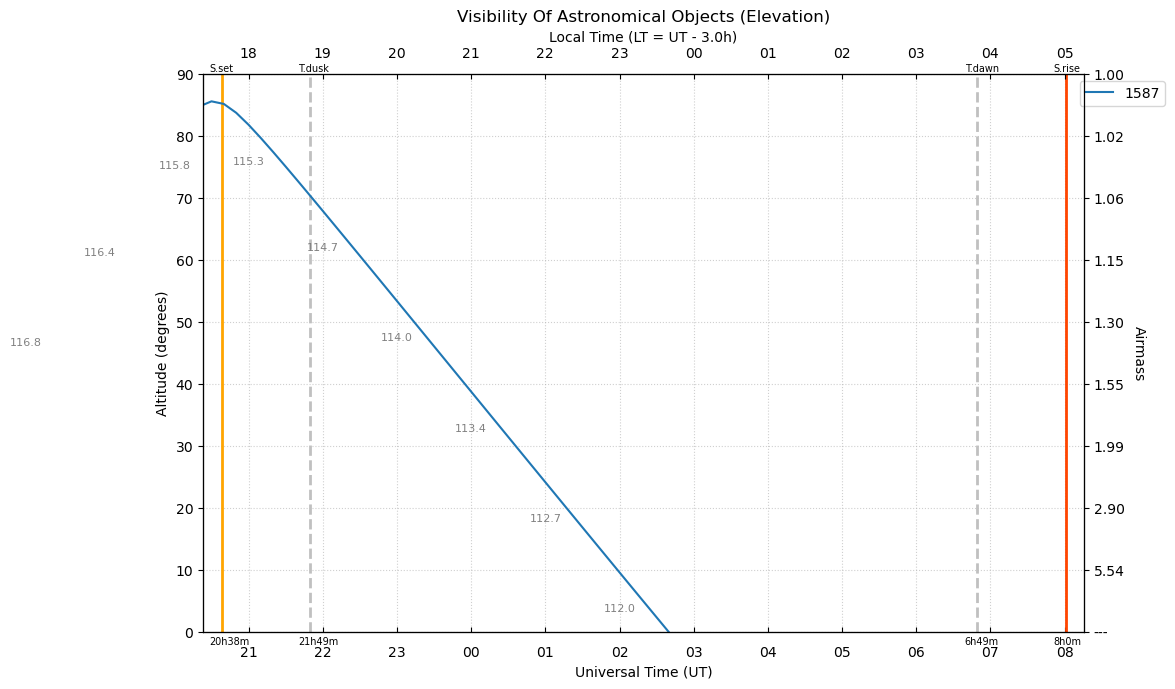

In [58]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from matplotlib.ticker import FuncFormatter # Import FuncFormatter

# --- 1. Define the Time Data and UT Offset ---
# The UTC Offset (e.g., Local Time = UTC - 3 hours)
# NOTE: Using a hypothetical UT_OFFSET = -3 for this example.
# Ensure 'date_str', 'maped.decimal_hours_to_time', 'sunset_1', etc., are defined in your environment.
# UT_OFFSET = -3 # hours. Change this to your actual offset.

# Placeholder date for the 'current' day (Oct 2, 2025)
# Using a dummy date_str and time values for the purpose of a runnable example
# date_str = "2025-10-02"
today = datetime.strptime(date_picker.value.strftime("%Y-%m-%d"), "%Y-%m-%d") 
tomorrow = today + timedelta(days=1)


# 1a. Calculate Local Time (LT) data points
LT_SUNSET = logi.parse_time(logi.decimal_hours_to_time(sunset_1), today)
LT_twilight_dusk = logi.parse_time(logi.decimal_hours_to_time(dusk_1), today)
LT_twilight_dawn = logi.parse_time(logi.decimal_hours_to_time(dawn_2), tomorrow)
LT_SUNRISE = logi.parse_time(logi.decimal_hours_to_time(sunrise_2), tomorrow)

# 1b. ***CRUCIAL STEP: Convert LT events to UT events***
# UT = LT - UT_OFFSET
UT_SUNSET = LT_SUNSET - timedelta(hours=utc_offset)
UT_twilight_dusk = LT_twilight_dusk - timedelta(hours=utc_offset)
UT_twilight_dawn = LT_twilight_dawn - timedelta(hours=utc_offset)
UT_SUNRISE = LT_SUNRISE - timedelta(hours=utc_offset)

# The data to be plotted (UT)
all_events_ut = [UT_SUNSET, UT_twilight_dusk, UT_twilight_dawn, UT_SUNRISE]

# --- 2. Create the Primary Plot (Now representing UT) ---
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the vertical lines using the UT events
ax.axvline(UT_SUNSET, color='orange', linestyle='-', linewidth=2)#, label='Sunset')
ax.axvline(UT_twilight_dusk, color='silver', linestyle='--', linewidth=2)#, label='Twilight Dusk')
ax.axvline(UT_twilight_dawn, color='silver', linestyle='--', linewidth=2)#, label='Twilight Dawn')
ax.axvline(UT_SUNRISE, color='orangered', linestyle='-', linewidth=2)#, label='Sunrise')


# Set y-axis and limits
ax.set_yticks([0,10,20,30,40,50,60,70,80,90])
ax.set_ylim(0, 90)


# Text sunset sunrise 
text_sunset = str(UT_SUNSET.hour)+'h'+str(UT_SUNSET.minute)+'m'
ax.text(UT_SUNSET-timedelta(minutes=10),-2,str(text_sunset), fontsize=7)
ax.text(UT_SUNSET-timedelta(minutes=10),90.5,str("S.set"), fontsize=7)


text_dusk = str(UT_twilight_dusk.hour)+'h'+str(UT_twilight_dusk.minute)+'m'
ax.text(UT_twilight_dusk-timedelta(minutes=10),-2,str(text_dusk), fontsize=7)
ax.text(UT_twilight_dusk-timedelta(minutes=10),90.5,str('T.dusk'), fontsize=7)


text_dawn = str(UT_twilight_dawn.hour)+'h'+str(UT_twilight_dawn.minute)+'m'
ax.text(UT_twilight_dawn-timedelta(minutes=10),-2,str(text_dawn), fontsize=7)
ax.text(UT_twilight_dawn-timedelta(minutes=10),90.5,'T.dawn', fontsize=7)


text_sunrise = str(UT_SUNRISE.hour)+'h'+str(UT_SUNRISE.minute)+'m'
ax.text(UT_SUNRISE-timedelta(minutes=10),-2,str(text_sunrise), fontsize=7)
ax.text(UT_SUNRISE-timedelta(minutes=10),90.5,'S.rise', fontsize=7)


# Set the x-axis limits based on the UT events
start_time_ut = min(all_events_ut) - timedelta(minutes=15)
end_time_ut = max(all_events_ut) + timedelta(minutes=15)
ax.set_xlim(start_time_ut, end_time_ut)

# --- Primary X-Axis (Bottom): Universal Time (UT) ---
# Since the data being plotted (UT_SUNSET, etc.) is already in UT, 
# we can use the standard DateFormatter.
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
# Adjust the location of the twin axis ticks
ax.tick_params(axis='x', direction='in', pad=10)


# Set the main axis label to UT
ax.set_xlabel("Universal Time (UT)")
ax.set_ylabel("Altitude (degrees)")
ax.grid(axis='x', linestyle=':', alpha=0.6)
ax.grid(axis='y', linestyle=':', alpha=0.6)






ax.plot(datetime_list,df_jpl.EL.to_list(),label='1587')

for dt, alt, elong in zip(datetime_list, df_jpl.EL, df_jpl.lunar_elong):
    if dt.minute == 0 and alt > 0:  # only annotate at the top of each hour when elevation > 0
        ax.text(
            dt, alt - 5,  # place text slightly below the altitude line
            f"{elong:.1f}",  # format lunar elongation
            ha='center', va='top', fontsize=8, color='gray'
        )



# --- 3. Create the Twin X-Axis (Top): Local Time (LT) ---

# Create a twin axis that shares the same y-axis
ax2 = ax.twiny() 
ax2.set_xlim(ax.get_xlim()) 

# --- Formatting the Local Time (LT) Axis ---

def lt_formatter(x, pos):
    """
    Custom formatter function to display Local Time (LT) hour.
    x is the plot coordinate (UT time number).
    LT = UT + UT_OFFSET. We shift the time by +UT_OFFSET.
    """
    # Convert the plot coordinate (Matplotlib date number) back to datetime object (UT time)
    dt_ut = mdates.num2date(x)
    
    # Calculate the corresponding Local Time
    dt_lt = dt_ut + timedelta(hours=utc_offset)
    
    # Return the formatted hour as a string
    return dt_lt.strftime('%H')

# Apply the same hourly locator
ax2.xaxis.set_major_locator(mdates.HourLocator(interval=1))

# Apply the custom LT formatter
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lt_formatter))

# Set the label for the new axis to LT
if utc_offset <= 0:
    ax2.set_xlabel(f"Local Time (LT = UT - {abs(utc_offset)}h)", fontsize=10)
else:
    ax2.set_xlabel(f"Local Time (LT = UT + {abs(utc_offset)}h)", fontsize=10)

# Adjust the location of the twin axis ticks
ax2.tick_params(axis='x', direction='in', pad=10)

# --- 4. Create the Twin Y-Axis for Airmass (The Solution) ---

# Create a third axis object that shares the same x-axis
# ax3 = ax.twinx() creates an axis on the right side
ax3 = ax.twinx() 

# Set the limits of ax3 to be the same as the primary y-axis (ax)
# This is crucial: the y-axis position (Elevation) maps directly to the ax3 position (Airmass)
ax3.set_ylim(ax.get_ylim())

# --- Formatting the Airmass Axis ---

# Use the same major locator as the primary y-axis (ax.get_yticks())
# This ensures the airmass labels align with the elevation grid lines.
y_ticks = ax.get_yticks()
ax3.set_yticks(y_ticks)

ax3.yaxis.set_major_formatter(FuncFormatter(logi.airmass_formatter))

# Set the label for the new axis
ax3.set_ylabel("Airmass", rotation=-90, labelpad=15)


plt.title("Visibility Of Astronomical Objects (Elevation)")
ax.legend(bbox_to_anchor=(1.10, 1.0))
plt.tight_layout()
plt.show()

In [ ]:
start_date_UT = " ".join([date_str,logi.decimal_hours_to_time(sunset_1)]) 
stop_date_UT = " ".join([date_str_2,logi.decimal_hours_to_time(sunrise_2)])


obj = Horizons(id='4257', location='Y28',epochs={'start':start_date_UT, 'stop':stop_date_UT,'step':"10min"})
eph = obj.ephemerides()

df_jpl = eph.to_pandas()

In [39]:
# 2. Create the Text Input Widget
coordinates_input = widgets.Text(
    value='14 09 46.7 +01 59 47', # Initial value
    placeholder= "HH MM SS.SS ±DD MM SS.S",
    description='Coordinates:',
    style={'description_width': 'initial'}
)

display(coordinates_input)

Text(value='14 09 46.7 +01 59 47', description='Coordinates:', placeholder='HH MM SS.SS ±DD MM SS.S', style=De…

In [40]:
coordinates_input.value

'14 09 46.7 +01 59 47'

In [8]:
widgets.Dropdown(
    options=[('One', 1), ('Two', 2), ('Three', 3)],
    value=2,
    description='Number:',
)

Dropdown(description='Number:', index=1, options=(('One', 1), ('Two', 2), ('Three', 3)), value=2)

In [13]:
widgets.Dropdown(
    options=[str(1985+i) for i in range(2031-1985)],
    value='2025',
    description='year:',
    disabled=False,
)    

Dropdown(description='year:', index=40, options=('1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992…

In [14]:
import ipywidgets as widgets
from IPython.display import display

# --- 1. Day Dropdown ---
day_options = [str(i) for i in range(1, 32)]
day_dropdown = widgets.Dropdown(
    options=day_options,
    value='1',
    description='Day:',
    disabled=False,
)

# --- 2. Month Dropdown ---
month_options = [
    ('January', 1), ('February', 2), ('March', 3),
    ('April', 4), ('May', 5), ('June', 6),
    ('July', 7), ('August', 8), ('September', 9),
    ('October', 10), ('November', 11), ('December', 12)
]
month_dropdown = widgets.Dropdown(
    options=month_options,
    value=2,
    description='Month:',
)

# --- 3. Year Dropdown ---
year_options = [str(i) for i in range(1985, 2031)]
year_dropdown = widgets.Dropdown(
    options=year_options,
    value='2025',
    description='Year:',
    disabled=False,
)

# --- 4. Combine with HBox ---
date_selector = widgets.HBox([day_dropdown, month_dropdown, year_dropdown])

# --- 5. Display the combined widget ---
display(date_selector)

In [18]:
import ipywidgets as widgets
from IPython.display import display
import datetime

# --- Create the DatePicker widget ---
date_picker = widgets.DatePicker(
    description='Select Date:',
    disabled=False,
    value=datetime.date(2025, 2, 27) # Example initial date
)

# --- Display the DatePicker ---
display(date_picker)

DatePicker(value=datetime.date(2025, 2, 27), description='Select Date:')

In [19]:
date_picker.value

datetime.date(2025, 2, 27)

In [8]:

# --------------------------------------------------------------------------
# --- Widget Implementation ---
# --------------------------------------------------------------------------

# 1. Define the main function that handles widget input
def calculate_jd_with_widget(date_string: str):
    """
    Processes the date string from the widget, calls the parser,
    calculates Julian Date, and prints the result.
    """
    # Clear previous output
    output_area.clear_output(wait=True)
    
    with output_area:
        print(f"Input String: {date_string}")
        print("-" * 30)
        
        try:
            # Call your flexible parser
            Y, M, D_decimal = maped.parse_date_to_YMD_flexible(date_string)
            
            # Print parsed components
            print(f"Parsed Y, M, D(decimal): ({Y}, {M}, {D_decimal:.8f})")
            
            # Call the Julian Date function
            julian_date = maped.calculate_julian_day(Y, M, D_decimal)
            
            # Print final result
            print("-" * 30)
            print(f"✨ Julian Date (JD): {julian_date:.8f}")
            
        except ValueError as e:
            # Handle parsing errors and display them
            print(f"❌ ERROR: {e}")
        except Exception as e:
            # Handle any other unexpected errors
            print(f"🛑 UNEXPECTED ERROR: {e}")


# 2. Create the Text Input Widget
date_time_input = widgets.Text(
    value='2025-10-06 13:30:45.123', # Initial value
    placeholder='YYYY-MM-DD HH:MM:SS.SS',
    description='Enter UTC Time:',
    style={'description_width': 'initial'}
)

# 3. Create an output area to display results
output_area = widgets.Output()

# 4. Create an interactive object linked to the input widget
# We use the interactive function to automatically link the widget's value 
# to the function's argument.
interactive_widget = widgets.interactive(
    calculate_jd_with_widget, 
    date_string=date_time_input
)

# 5. Display the widget and the output area
display(interactive_widget, output_area)

interactive(children=(Text(value='2025-10-06 13:30:45.123', description='Enter UTC Time:', placeholder='YYYY-M…

Output()

In [1]:
from geopy.geocoders import Nominatim
from datetime import datetime
import pytz

def get_utc_offset(lat, lon):
    geolocator = Nominatim(user_agent="timezone_app")
    location = geolocator.reverse(f"{lat}, {lon}", language='en')
    
    # This gives you the location, but not directly the timezone
    # You'd still need a timezone lookup
    print(location.raw)

# This approach has limitations without timezone data

In [1]:
from tzfpy import get_tz
import pytz
from datetime import datetime

def get_utc_offset_from_coords(lat, lon):
    """
    Get UTC offset from latitude and longitude using tzfpy
    
    Args:
        lat: Latitude (float)
        lon: Longitude (float)
        
    Returns:
        tuple: (offset_hours, timezone_name) or (None, None) if failed
    """
    try:
        # Get timezone name from coordinates
        tz_name = get_tz(lon, lat)  # Note: tzfpy uses (lon, lat) order
        
        if tz_name is None:
            print("Could not find timezone for these coordinates")
            return None, None
        
        # Get the timezone object
        tz = pytz.timezone(tz_name)
        
        # Get current UTC offset (including DST if applicable)
        now = datetime.now(tz)
        offset = now.utcoffset().total_seconds() / 3600
        
        return offset, tz_name
        
    except Exception as e:
        print(f"Error: {e}")
        return None, None


# Example usage
if __name__ == "__main__":
    # Test with different coordinates
    test_locations = [
        (40.7128, -74.0060, "New York"),
        (51.5074, -0.1278, "London"),
        (-23.5505, -46.6333, "São Paulo"),
        (35.6762, 139.6503, "Tokyo"),
        (-22.9068, -43.1729, "Rio de Janeiro"),
    ]
    
    for lat, lon, name in test_locations:
        print(f"\n--- {name} ---")
        print(f"Coordinates: ({lat}, {lon})")
        
        offset, tz_name = get_utc_offset_from_coords(lat, lon)
        
        if offset is not None:
            print(f"UTC Offset: {offset:+.1f} hours")
            print(f"Timezone: {tz_name}")
            
            # Show current time in that timezone
            tz = pytz.timezone(tz_name)
            local_time = datetime.now(tz)
            print(f"Current time: {local_time.strftime('%Y-%m-%d %H:%M:%S %Z')}")
        else:
            print("Could not determine UTC offset")



--- New York ---
Coordinates: (40.7128, -74.006)
UTC Offset: -4.0 hours
Timezone: America/New_York
Current time: 2025-10-06 13:33:58 EDT

--- London ---
Coordinates: (51.5074, -0.1278)
UTC Offset: +1.0 hours
Timezone: Europe/London
Current time: 2025-10-06 18:33:58 BST

--- São Paulo ---
Coordinates: (-23.5505, -46.6333)
UTC Offset: -3.0 hours
Timezone: America/Sao_Paulo
Current time: 2025-10-06 14:33:58 -03

--- Tokyo ---
Coordinates: (35.6762, 139.6503)
UTC Offset: +9.0 hours
Timezone: Asia/Tokyo
Current time: 2025-10-07 02:33:58 JST

--- Rio de Janeiro ---
Coordinates: (-22.9068, -43.1729)
UTC Offset: -3.0 hours
Timezone: America/Sao_Paulo
Current time: 2025-10-06 14:33:58 -03


In [ ]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

# # Create a sample DataFrame
# df = pd.read_csv('C:/Users/michi/OneDrive/Escritorio/phase_curves_project/MPC_observatory_codes/MPC_OBS_CODES.csv')

# Create a sample DataFrame
data = {
    'Name': ['Alice', 'Bob', 'Charlie', 'David'],
    'Age': [25, 30, 35, 40],
    'City': ['New York', 'London', 'Paris', 'Tokyo']
}
df = pd.DataFrame(data)

# Define a function to display the selected row
def select_row_by_name(name):
    selected_row = df[df['Name'] == name]
    display(selected_row)

# Create a Dropdown widget with options from the 'Name' column
name_dropdown = widgets.Dropdown(
    options=df['Name'].tolist(),
    value=df['Name'].iloc[0],  # Set initial value
    description='Select Name:'
)

# Link the dropdown to the function using interactive
widgets.interactive(select_row_by_name, name=name_dropdown)

# Display the dropdown widget
display(name_dropdown)

Dropdown(description='Select Name:', options=('Alice', 'Bob', 'Charlie', 'David'), value='Alice')

In [11]:
from astroquery.jplsbdb import SBDB
from astroquery.jplhorizons import Horizons
import re

In [25]:
target_id = '1853'

###### Query the Target Body to retrieve the target_id according to the JPL format
sbdb = SBDB.query(target_id)

# shortname = sbdb['object']['shortname']
# fullname = sbdb['object']['fullname']
# match_id = re.search(r'\((.*?)\)', fullname)
# target_id_JPL = match_id.group(1)

SBDB.clear_cache()




# start_date_UT = df_obs_band['Date (UT) str'].min()
# stop_date_UT = df_obs_band['Date (UT) str'].max()

# obj = Horizons(id=target_id_JPL, location=500,epochs={'start':start_date_UT, 'stop':stop_date_UT,'step':"1days"})
# eph = obj.ephemerides()

# df_jpl = eph.to_pandas()

sbdb['object']

OrderedDict([('des', '1853'),
             ('orbit_class',
              OrderedDict([('name', 'Main-belt Asteroid'), ('code', 'MBA')])),
             ('pha', False),
             ('neo', False),
             ('kind', 'an'),
             ('orbit_id', '71'),
             ('fullname', '1853 McElroy (1957 XE)'),
             ('spkid', '20001853'),
             ('prefix', None),
             ('shortname', '1853 McElroy')])

In [28]:
start_date_UT = '2025-10-15 21:00'#df_obs_band['Date (UT) str'].min()
stop_date_UT = '2025-10-16 21:00' #df_obs_band['Date (UT) str'].max()

obj = Horizons(id='1853', location='Y28',epochs={'start':start_date_UT, 'stop':stop_date_UT,'step':"10min"})
eph = obj.ephemerides()

df_jpl = eph.to_pandas()

In [24]:
df_jpl.columns

Index(['targetname', 'datetime_str', 'datetime_jd', 'H', 'G', 'solar_presence',
       'lunar_presence', 'RA', 'DEC', 'RA_app', 'DEC_app', 'RA_rate',
       'DEC_rate', 'AZ', 'EL', 'AZ_rate', 'EL_rate', 'sat_X', 'sat_Y',
       'sat_PANG', 'siderealtime', 'airmass', 'magextinct', 'V', 'surfbright',
       'illumination', 'illum_defect', 'sat_sep', 'sat_vis', 'ang_width',
       'PDObsLon', 'PDObsLat', 'PDSunLon', 'PDSunLat', 'SubSol_ang',
       'SubSol_dist', 'NPole_ang', 'NPole_dist', 'EclLon', 'EclLat', 'r',
       'r_rate', 'delta', 'delta_rate', 'lighttime', 'vel_sun', 'vel_obs',
       'elong', 'elongFlag', 'alpha', 'lunar_elong', 'lunar_illum',
       'sat_alpha', 'sunTargetPA', 'velocityPA', 'OrbPlaneAng',
       'constellation', 'TDB-UT', 'ObsEclLon', 'ObsEclLat', 'NPole_RA',
       'NPole_DEC', 'GlxLon', 'GlxLat', 'solartime', 'earth_lighttime',
       'RA_3sigma', 'DEC_3sigma', 'SMAA_3sigma', 'SMIA_3sigma', 'Theta_3sigma',
       'Area_3sigma', 'RSS_3sigma', 'r_3sigma', 'r_r

In [30]:
df_jpl[['datetime_str','EL']]

,datetime_str,EL
0,2025-Oct-15 21:00,81.100171
1,2025-Oct-15 21:10,79.655661
2,2025-Oct-15 21:20,77.886583
3,2025-Oct-15 21:30,75.914835
4,2025-Oct-15 21:40,73.814466
...,...,...
140,2025-Oct-16 20:20,81.130990
141,2025-Oct-16 20:30,82.088213
142,2025-Oct-16 20:40,82.353357
143,2025-Oct-16 20:50,81.858494
